## Preparación de los datos

En [este tutorial](https://jvn.io/aakashns/a1b40b04f5174a18bd05b17e3dffb0f0), se explica el procedimiento (en inglés).

Primero importamos las librerías y funciones que vamos a utilizar.

In [1]:
#Librerias de machine learning
import torch #PyTorch
import torchvision 
#Libreria para procesar imágenes para ML
import numpy as np #Librería para hacer operaciones vectoriales y matriciales
import torch.nn as nn #Librería de torch con funciones para hacer cosas con redes neuronales
import torch.nn.functional as F #Lo mismo que nn pero le pasas los argumentos DENTRO de la funcion
import torchvision.transforms #Sirve para hacer transformaciones a la imágenes por ej rotaciones 
from torchvision.datasets import MNIST #Dataset que vamos a usar. Lo importamos desde PyTorch
from torch.utils.data.dataloader import DataLoader #Sirve para cargar los datos
from torch.utils.data import random_split #Sirve para partir listas de manera aleatoria

#Librerias para plotear
from torchvision.utils import make_grid #para hacer un ploteo con varias imagenes del dataset
import matplotlib.pyplot as plt
%matplotlib inline

import time

Descargamos los datos y creamos un dataset de PyTorch. Los datos serán imágenes de 28x28 píxeles en blanco y negro (es decir, cada imágen será una matriz 28x28x1) de números escritos. Este famoso conjunto de datos se denomina `MNIST` y es una clase dentro de la librería `torchvision.datasets`, de donde lo descargaremos. Vamos a utilizar un conjunto de imagenes para el entrenamiento y otro con imágenes distintas para el testeo o evaluación.

In [2]:
# Load and transform data
train_ds = MNIST(root='/tmp', 
                 train=True, 
                 download=True, 
                 transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),#transforma la img a tensores (matrices)
                            torchvision.transforms.Normalize((0.1307,), (0.3081,))]) #normaliza 
                  )

test_ds = MNIST(root='/tmp', 
                train=False, 
                download=True, 
                transform=torchvision.transforms.Compose([
                          torchvision.transforms.ToTensor(),#transforma la img a tensores (matrices)
                          torchvision.transforms.Normalize((0.1307,), (0.3081,))]) #normaliza 
                  )

|          | 0/? [00:00<?, ?it/s]

Extracting /tmp/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/MNIST/raw


|          | 0/? [00:00<?, ?it/s]

Extracting /tmp/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/MNIST/raw


|          | 0/? [00:00<?, ?it/s]

Extracting /tmp/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/MNIST/raw


|          | 0/? [00:00<?, ?it/s]

Extracting /tmp/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/MNIST/raw
Processing...
Done!


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729138878/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Veamos la longitud de cada dataset:

In [3]:
len(train_ds),len(test_ds)

(60000, 10000)

Ahora, usamos la función random_split para separar el conjunto de entrenamiento (60000 imagenes) en dos:

Conjunto de entrenamiento(train): contendrá 80% del total de imagenes en train_ds.

Conjunto de validacióno(val): contendrá el restante 20% del total de imagenes en train_ds.

Ambos subconjuntos se utilizaran *durante* el entrenamiento. El conjunto de testeo NO se utilizará durante el entreamientp, si no despues de concluir con el mismo.

In [4]:
train_size = 48000
val_size = len(train_ds)- train_size

train_ds, val_ds = random_split(train_ds, [train_size, val_size])
len(train_ds), len(val_ds)

(48000, 12000)

Creamos los 'PyTorch data loaders' para el cojunto de entrenamiento y validación. Básicamente son funciones que ya vienen incluidas en PyTorch mediante las cuales podremos ordenar los datos y realizar un entrenamiento en mini-batches (lotes) del tamaño que elijamos, entre otras funcionaliades. Por ejemplo:

- shuffle (bool): Sirve para indicar si queremos que los datos se reorganicen luego de cada epoca de corrida.
- num_workers (int, optional): Cuántos subprocesos usar para la carga de los datos. 0 significa que los datos se cargarán en el proceso principal. 
- pin_memory (bool, optional): Si está en True, el data loader va a copiar los Tensores en la memoria  CUDA antes de devoverlos. Sirve particularmente si vamos a usar el acelerador. 

Más documentación: https://pytorch.org/docs/stable/data.html

In [5]:
#Defino tamaño de los batch
batch_size=24   

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

Vamos a plotear un minibatch de imagenes. Para ello utilizamos la función `make_grid` de `torchvision` y el método `.permute`. Necesitamos este último porque la forma del tensor de las imágenes cargadas en el dataloader es [1,28,28], es decir que los canales están el la dimensión '0' del tensor (la primera). Pero la función `make_grid` toma como argumento tensores (imágenes) de la forma [ancho, alto, canales], por lo que si no hacemos este cambio con las dimensiones la funcion tira un error. Por lo tanto, con el método permute le pedimos que para cada tensor del dataloader, haga el siguiente cambio antes de pasarle en tensor a la función `make_grid`:

canales dim 0-> dim 2

ancho   dim 1-> dim 0

alto    dim2 -> dim 1

images.shape: torch.Size([24, 1, 28, 28])


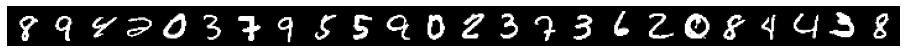

In [6]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=100).permute((1, 2, 0)))
    break

## Mover los datos al GPU

A continuación defino una serie de funciones cuyo objetivo es mover los datos al GPU para poder utilizarlo y entrenar la red con este dispositivo. Un GPU es una unidad de procesamiento gráfico (Graphics Processing Unit por sus siglas en inglés) es un coprocesador dedicado al procesamiento de gráficos u operaciones de punto flotante. Se utilizan los GPU en estos casos porque el CPU solo muchas veces no alcanza, tarda demasiado tiempo en entrenar la red, incluso en algunos casos es imposible. 

En Kaggle, el GPU se activa en settings -> Accelerator -> GPU.
En Colab, 

No es posible utilizar este dispositivo locamente a no ser que la computadora tenga incorporado uno de ellos.

In [7]:
torch.cuda.is_available() #Detecta si hay un GPU disponible

True

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
#Elige un GPU si hay uno disponible. Si no, elige un CPU.
device = get_default_device()
device

device(type='cuda')

## Modelo



Se considerará un modelo similar al publicado en el trabajo [1], con algunos parámetros cambiados.
Se trata de un autoencoder convolucional simétrico, es decir que la parte del encoder es un reflejo de la parte de decoder. El encoder es la sección donde la información "se comprime" hasta llegar al espacio latente, y luego con el decoder se "decodifica" esta información. 

Las capas del modelo estarán compuestas por convoluciones 2D en el caso del encoder y por convoluciones traspuestas 2d en el caso del decoder. Ya existen funciones en Pytorch que realizan estos cálculos, y necesitan que se les pase los siguientes parámetros:

Stride s: son la cantidad de pasos que avanza el kernel sobre la matriz de entrada.

Padding p : es el borde que se le agrega a la matriz de entrada.

Dilation d: espacio entre los elementos del kernel.

Kernel size f: el tamaño del kernel o núcleo de la convolución.

La cantidad de canales de entrada y salida es un parámetro que directamente se le pasa a la función de convolución.

De acuerdo a estos parámetros, la función calcula el tamaño 2d de la matriz de salida:

**Convolución**

Si la imagen de entrada es un Tensor cuadrado de tamaño **nxn** (largoxancho) y el kernel de la convoución es una matriz cuarada de fxf de tamaño, entonces las salida de la convolución, si la misma tiene stride y padding, será una matriz cuadrada de tamaño:

nxn $\circledast$ fxf = $[\frac{n + 2p - d(f-1) - 1}{s}+1]$ x $[\frac{n + 2p - d(f-1) - 1}{s}+1 ]$

**Convolución Traspuesta**

Si la imagen de entrada es un Tensor cuadrado de tamaño **nxn** (largoxancho) y el kernel de la convoución es una matriz cuarada de fxf de tamaño, entonces las salida de la convolución, si la misma tiene stride y padding, será una matriz cuadrada de tamaño:

nxn $\circledast$ fxf = $[s(n-1) - 2p + d(f-1) + 1]$ x $[s(n-1) - 2p + d(f-1) + 1]$

Explicación detallada sobre [convolución traspuesta](https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8) y [documentación](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html).
 
Se definirán funciones auxiliares para calcular el tamaño de la salida y del kernel.

In [10]:
def conv_outsize(in_size, f , s, p, d=1):
    out_size = ((in_size + 2*p - d(f-1) - 1)/s) + 1
    return out_size

def get_fsize(in_size, out_size, p=1, s=2, d=1):
    '''Calcula el tamaño de kernel que necesito si quiero obtener una salida de tamaño out_size'''
    ker_size= n + 2*p - s*(out_size-1)
    return ker_size

def same_conv(in_size,out_size, p=1):
    ker_size = in_size + 2*p + 1 - out_size
    return ker_size

def deconv_out(in_size, f , s=2, p=1, d=1):
    out_size = s*(in_size-1) - 2*p + d*(f-1) + 1
    return out_size

Definimos una subclase de la clase nn.Module de Pytorch que contiene cada paso de la secuencia que se debe llevar a cabo para entrenar el modelo. [Fuente](http://jovian.ai)

In [11]:
def accuracy(original, pred):
    return torch.abs(original-pred).float().mean()

In [12]:
class Train(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)            # Generate predictions
        loss = F.mse_loss(out,images) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.mse_loss(out, images)   # Calculate loss
        acc = accuracy(images, out)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

Ahora definimos el primer modelo, cuya arquitectura será similar a la que se muestra en la imagen, excepto que se utilizará stride=1 (same convolutions). Este modelo se propone en el trabajo [1].
![arquitectura modelo1](https://www.researchgate.net/profile/Xifeng-Guo/publication/320658590/figure/fig1/AS:614154637418504@1523437284408/The-structure-of-proposed-Convolutional-AutoEncoders-CAE-for-MNIST-In-the-middle-there.png)  

Para ello utilizaremos la función nn.Sequential de Pytorch, que nos ayudará a encadenar las diferentes secciones. El modelo será una subclase de la clase Train, y contendrá un encoder y un decoder. Para llamar al modelo, recibirá como parámetro el tamaño de capa oculta.

In [13]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

In [14]:
class ConvAutoenc(Train):
    
    def __init__(self, hidden_size):
        super().__init__() #uso esto porque la clase Autoencoder es subclase de otra
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1), #out size= 14x14x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), #out size= 7x7x64
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0), #out size= 3x3x64
            nn.ReLU(),
            nn.Flatten()
        ) #out size= 1152 = 3*3*128
            
        self.hidden = nn.Sequential(
            nn.Linear(1152, hidden_size),
            nn.Linear(hidden_size, 1152),
            nn.Dropout(0.1),
            nn.ReLU()
            )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=3,stride=2, padding=0), 
            nn.ReLU(),#out = 7x7x64
            nn.ConvTranspose2d(in_channels=64,out_channels=32,kernel_size=4, stride=2, padding=1),
            nn.ReLU(),#out = 14x14x32
            nn.ConvTranspose2d(in_channels=32,out_channels=1,kernel_size=4, stride=2, padding=1)
        )
        
    def forward(self, xb):
        out = self.encoder(xb) #out size= 1152 = 3*3*128
        out = self.hidden(out) #out size= 1152
        z = out.view(out.shape[0], 128, 3, 3)
        out = self.decoder(z)
        return out

## Prueba
Crearemos un modelo que contenga una sola capa oculta con 512 activaciones; este no es el entrenamiento definitivo, sólo vamos a ver si el código funciona antes de entrenar.

In [15]:
ten = torch.tensor([[1,2,3],
                  [1,2,3],
                  [1,2,3]])
ten.view(9)
ten.view((3,3))

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

In [16]:
hidden_size = 10 # se puede cambiar

model = ConvAutoenc(hidden_size = 10)
model

ConvAutoenc(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (hidden): Sequential(
    (0): Linear(in_features=1152, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1152, bias=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

Veamos si los tamaños de las salidas son los esperados. 

In [17]:
for t in model.parameters():
    print(t.shape)
#imprime [canales de salida, canales de entrada, kernel]
#canales de salida

torch.Size([32, 1, 4, 4])
torch.Size([32])
torch.Size([64, 32, 4, 4])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([10, 1152])
torch.Size([10])
torch.Size([1152, 10])
torch.Size([1152])
torch.Size([128, 64, 3, 3])
torch.Size([64])
torch.Size([64, 32, 4, 4])
torch.Size([32])
torch.Size([32, 1, 4, 4])
torch.Size([1])


Generemos algunas salidas del modelo, para ver cómo funciona.

In [18]:
for images, labels in train_dl:
    outputs = model(images)
    loss = F.mse_loss(outputs, images)
    accu = accuracy(images, outputs)
    print('Loss:', loss.item())
    break


print('outputs.shape : ', outputs.size)
print('Sample outputs :\n', outputs[:2].data)
print('image shape in loader ', outputs[:2].data)
accu

Loss: 1.013484001159668
outputs.shape :  <built-in method size of Tensor object at 0x7f1c3d3bbb40>
Sample outputs :
 tensor([[[[0.0325, 0.0690, 0.0598,  ..., 0.0708, 0.0630, 0.0835],
          [0.0655, 0.0676, 0.0421,  ..., 0.0819, 0.0345, 0.0877],
          [0.0485, 0.0556, 0.0863,  ..., 0.0680, 0.0799, 0.0839],
          ...,
          [0.0732, 0.0848, 0.0455,  ..., 0.0652, 0.0494, 0.0775],
          [0.0431, 0.0635, 0.1028,  ..., 0.0434, 0.0959, 0.0853],
          [0.0739, 0.0842, 0.0645,  ..., 0.0788, 0.0597, 0.0675]]],


        [[[0.0321, 0.0708, 0.0588,  ..., 0.0737, 0.0613, 0.0802],
          [0.0674, 0.0640, 0.0445,  ..., 0.0759, 0.0326, 0.0854],
          [0.0467, 0.0625, 0.0851,  ..., 0.0686, 0.0838, 0.0867],
          ...,
          [0.0696, 0.0798, 0.0399,  ..., 0.0622, 0.0483, 0.0787],
          [0.0439, 0.0633, 0.1027,  ..., 0.0405, 0.0896, 0.0850],
          [0.0734, 0.0786, 0.0607,  ..., 0.0815, 0.0608, 0.0652]]]])
image shape in loader  tensor([[[[0.0325, 0.0690, 0.05

tensor(0.7390, grad_fn=<MeanBackward0>)

In [19]:
for xb, yb in val_dl:
    print('xb shape', xb.shape)
    print('yb shape', yb.shape)
    break

xb shape torch.Size([24, 1, 28, 28])
yb shape torch.Size([24])


## Entrenando al Modelo

Vamos a definir algunas funciones que servirán para entrenar el modelo. 

El entrenamiento se realizará con un learning rate variable a lo largo de los batches. Se podría hacer con un lr constante haciendo algunas modificacione en el código.

Más documentacion sobre [lr variables](http://https://pytorch.org/docs/stable/optim.html?highlight=one%20cycle#torch.optim.lr_scheduler.OneCycleLR)

In [20]:
@torch.no_grad()
def evaluate(model, val_loader):
    '''
    Funcion que sirve para evaluar una vez, para probar.
    '''
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  grad_clip=None, opt_func=torch.optim.SGD):
    
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result) #imprime lo que vamos obteniendo por cada epoca
        history.append(result)
    return history

Con lo siguiente podremos ver cómo se desempeña el modelo con un conjunto inicial de pesos. Si vamos a entrenar definitivamente, recomiendo reiniciar el kerne y saltar este paso.

In [21]:
train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(val_dl, device)

In [22]:
model = to_device(ConvAutoenc(10), device)
history = [evaluate(model, val_loader)]
history

[{'val_loss': 1.0095126628875732, 'val_acc': 0.6264312863349915}]

Elegimos los parámetros con los que entrenaremos

In [23]:
epochs = 30
max_lr = 0.1
grad_clip = 0.1
weight_decay = 1e-4
input_size = 784
batch_size = 1000

Volvemos a cargar los datasets en los loaders porque modificamos el tamaño del batch.

In [24]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
    
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(val_dl, device)
to_device(model, device);

Entrenaremos con diferentes tamaños de capas ocultas para después comparar con cuál se desempeña mejor el modelo.

In [25]:
hidden_size0 = 10

model0 = to_device(ConvAutoenc(hidden_size0), device)

history0 = [evaluate(model0, val_loader)]
history0

[{'val_loss': 1.0364898443222046, 'val_acc': 0.8214189410209656}]

In [26]:
start = time.time()

history0 += fit_one_cycle(epochs, max_lr, model0, train_loader, val_loader,grad_clip=grad_clip)

end = time.time()
time0= (end - start)/60 #Wall time

Epoch [0], train_loss: 1.0135, val_loss: 1.0038, val_acc: 0.6664
Epoch [1], train_loss: 0.9965, val_loss: 0.9907, val_acc: 0.6909
Epoch [2], train_loss: 0.9616, val_loss: 0.8645, val_acc: 0.6653
Epoch [3], train_loss: 0.7184, val_loss: 0.6706, val_acc: 0.4960
Epoch [4], train_loss: 0.6271, val_loss: 0.5542, val_acc: 0.4360
Epoch [5], train_loss: 0.4864, val_loss: 0.4159, val_acc: 0.3633
Epoch [6], train_loss: 0.4010, val_loss: 0.3566, val_acc: 0.3226
Epoch [7], train_loss: 0.3512, val_loss: 0.3192, val_acc: 0.3001
Epoch [8], train_loss: 0.3208, val_loss: 0.2954, val_acc: 0.2806
Epoch [9], train_loss: 0.3025, val_loss: 0.2771, val_acc: 0.2704
Epoch [10], train_loss: 0.2892, val_loss: 0.2649, val_acc: 0.2602
Epoch [11], train_loss: 0.2765, val_loss: 0.2565, val_acc: 0.2545
Epoch [12], train_loss: 0.2685, val_loss: 0.2471, val_acc: 0.2467
Epoch [13], train_loss: 0.2604, val_loss: 0.2403, val_acc: 0.2409
Epoch [14], train_loss: 0.2535, val_loss: 0.2353, val_acc: 0.2370
Epoch [15], train_lo

In [27]:
hidden_size1 = 64 

model1 = to_device(ConvAutoenc(hidden_size1), device)

history1 = [evaluate(model1, val_loader)]
history1

[{'val_loss': 1.002488374710083, 'val_acc': 0.6839584708213806}]

In [28]:
%%time
start = time.time()

history1 += fit_one_cycle(epochs, max_lr, model1, train_loader, val_loader,grad_clip=grad_clip)

end = time.time()
time1 = (end - start)/60 #Wall time

Epoch [0], train_loss: 0.9994, val_loss: 0.9979, val_acc: 0.6952
Epoch [1], train_loss: 0.9933, val_loss: 0.9878, val_acc: 0.6948
Epoch [2], train_loss: 0.9673, val_loss: 0.9237, val_acc: 0.6674
Epoch [3], train_loss: 0.7585, val_loss: 0.6772, val_acc: 0.5068
Epoch [4], train_loss: 0.6258, val_loss: 0.5390, val_acc: 0.4291
Epoch [5], train_loss: 0.4628, val_loss: 0.3766, val_acc: 0.3399
Epoch [6], train_loss: 0.3918, val_loss: 0.2958, val_acc: 0.2797
Epoch [7], train_loss: 0.2758, val_loss: 0.2320, val_acc: 0.2419
Epoch [8], train_loss: 0.2303, val_loss: 0.1959, val_acc: 0.2178
Epoch [9], train_loss: 0.2018, val_loss: 0.1721, val_acc: 0.2017
Epoch [10], train_loss: 0.1819, val_loss: 0.1547, val_acc: 0.1892
Epoch [11], train_loss: 0.1669, val_loss: 0.1423, val_acc: 0.1799
Epoch [12], train_loss: 0.1566, val_loss: 0.1334, val_acc: 0.1723
Epoch [13], train_loss: 0.1460, val_loss: 0.1246, val_acc: 0.1658
Epoch [14], train_loss: 0.1386, val_loss: 0.1176, val_acc: 0.1600
Epoch [15], train_lo

In [29]:
hidden_size2 = 128

model2 = to_device(ConvAutoenc(hidden_size2), device)

history2 = [evaluate(model2, val_loader)]
history2

[{'val_loss': 1.0491634607315063, 'val_acc': 0.5523210763931274}]

In [30]:
%%time
start = time.time()

history2 += fit_one_cycle(epochs, max_lr, model2, train_loader, val_loader, grad_clip=grad_clip)

end = time.time()
time2 = (end - start)/60 #Wall time

Epoch [0], train_loss: 1.0115, val_loss: 0.9961, val_acc: 0.7418
Epoch [1], train_loss: 0.9867, val_loss: 0.9793, val_acc: 0.6846
Epoch [2], train_loss: 0.9603, val_loss: 0.9123, val_acc: 0.6691
Epoch [3], train_loss: 0.7367, val_loss: 0.6687, val_acc: 0.4922
Epoch [4], train_loss: 0.6098, val_loss: 0.5099, val_acc: 0.4077
Epoch [5], train_loss: 0.4397, val_loss: 0.3579, val_acc: 0.3149
Epoch [6], train_loss: 0.4369, val_loss: 0.2898, val_acc: 0.2664
Epoch [7], train_loss: 0.2671, val_loss: 0.2244, val_acc: 0.2283
Epoch [8], train_loss: 0.2209, val_loss: 0.1889, val_acc: 0.2062
Epoch [9], train_loss: 0.1918, val_loss: 0.1654, val_acc: 0.1928
Epoch [10], train_loss: 0.1722, val_loss: 0.1472, val_acc: 0.1796
Epoch [11], train_loss: 0.1566, val_loss: 0.1347, val_acc: 0.1709
Epoch [12], train_loss: 0.1455, val_loss: 0.1252, val_acc: 0.1633
Epoch [13], train_loss: 0.1361, val_loss: 0.1164, val_acc: 0.1567
Epoch [14], train_loss: 0.1285, val_loss: 0.1105, val_acc: 0.1525
Epoch [15], train_lo

In [31]:
hidden_size3 = 256

model3 = to_device(ConvAutoenc(hidden_size3), device)

history3 = [evaluate(model3, val_loader)]
history3

[{'val_loss': 1.0084922313690186, 'val_acc': 0.6527111530303955}]

In [32]:
%%time
start = time.time()

history3 += fit_one_cycle(epochs, max_lr, model3, train_loader, val_loader, grad_clip=grad_clip)

end = time.time()
time3 = (end - start)/60 #Wall time

Epoch [0], train_loss: 1.0011, val_loss: 0.9978, val_acc: 0.6924
Epoch [1], train_loss: 0.9927, val_loss: 0.9868, val_acc: 0.6889
Epoch [2], train_loss: 0.9669, val_loss: 0.9116, val_acc: 0.6738
Epoch [3], train_loss: 0.7284, val_loss: 0.6581, val_acc: 0.4857
Epoch [4], train_loss: 0.5758, val_loss: 0.4614, val_acc: 0.3777
Epoch [5], train_loss: 0.3893, val_loss: 0.3106, val_acc: 0.2843
Epoch [6], train_loss: 0.2837, val_loss: 0.2295, val_acc: 0.2335
Epoch [7], train_loss: 0.2305, val_loss: 0.1881, val_acc: 0.2077
Epoch [8], train_loss: 0.1867, val_loss: 0.1630, val_acc: 0.1893
Epoch [9], train_loss: 0.1653, val_loss: 0.1406, val_acc: 0.1760
Epoch [10], train_loss: 0.1482, val_loss: 0.1274, val_acc: 0.1652
Epoch [11], train_loss: 0.1364, val_loss: 0.1171, val_acc: 0.1566
Epoch [12], train_loss: 0.1254, val_loss: 0.1079, val_acc: 0.1496
Epoch [13], train_loss: 0.1180, val_loss: 0.1010, val_acc: 0.1437
Epoch [14], train_loss: 0.1111, val_loss: 0.0960, val_acc: 0.1388
Epoch [15], train_lo

In [33]:
hidden_size4 = 512

model4 = to_device(ConvAutoenc(hidden_size4), device)

history4 = [evaluate(model4, val_loader)]
history4

[{'val_loss': 1.0423429012298584, 'val_acc': 0.8316307067871094}]

In [34]:
%%time
start = time.time()

history4 += fit_one_cycle(epochs, max_lr, model4, train_loader, val_loader, grad_clip=grad_clip)

end = time.time()
time4 = (end - start)/60 #Wall time

Epoch [0], train_loss: 1.0155, val_loss: 1.0033, val_acc: 0.6658
Epoch [1], train_loss: 0.9984, val_loss: 0.9967, val_acc: 0.6906
Epoch [2], train_loss: 0.9908, val_loss: 0.9833, val_acc: 0.6905
Epoch [3], train_loss: 0.9573, val_loss: 0.8417, val_acc: 0.6586
Epoch [4], train_loss: 0.7011, val_loss: 0.6412, val_acc: 0.4660
Epoch [5], train_loss: 0.5275, val_loss: 0.4116, val_acc: 0.3601
Epoch [6], train_loss: 0.3548, val_loss: 0.3465, val_acc: 0.3285
Epoch [7], train_loss: 0.2629, val_loss: 0.2131, val_acc: 0.2401
Epoch [8], train_loss: 0.2062, val_loss: 0.1743, val_acc: 0.2127
Epoch [9], train_loss: 0.1749, val_loss: 0.1495, val_acc: 0.1945
Epoch [10], train_loss: 0.1544, val_loss: 0.1332, val_acc: 0.1813
Epoch [11], train_loss: 0.1397, val_loss: 0.1210, val_acc: 0.1714
Epoch [12], train_loss: 0.1287, val_loss: 0.1108, val_acc: 0.1634
Epoch [13], train_loss: 0.1196, val_loss: 0.1046, val_acc: 0.1582
Epoch [14], train_loss: 0.1129, val_loss: 0.0971, val_acc: 0.1517
Epoch [15], train_lo

## Ploteos

### Error cuadrático medio de validacion

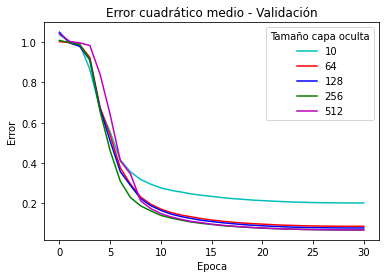

In [35]:
vloss0 = [x['val_loss'] for x in history0]
vloss1 = [x['val_loss'] for x in history1]
vloss2 = [x['val_loss'] for x in history2]
vloss3 = [x['val_loss'] for x in history3]
vloss4 = [x['val_loss'] for x in history4]
plt.plot(vloss0, '-c', label='10')
plt.plot(vloss1, '-r', label='64')
plt.plot(vloss2, '-b', label='128')
plt.plot(vloss3, '-g', label='256')
plt.plot(vloss4, '-m', label='512')

plt.xlabel('Epoca')
plt.ylabel('Error')
plt.title('Error cuadrático medio - Validación')
plt.legend(title='Tamaño capa oculta')

### Error cuadrático medio de entrenamiento

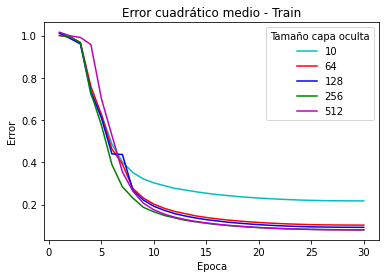

In [36]:
tloss0 = [x.get('train_loss') for x in history0]
tloss1 = [x.get('train_loss') for x in history1]
tloss2 = [x.get('train_loss') for x in history2]
tloss3 = [x.get('train_loss') for x in history3]
tloss4 = [x.get('train_loss') for x in history4]

plt.plot(tloss0, '-c', label='10')
plt.plot(tloss1, '-r', label='64')
plt.plot(tloss2, '-b', label='128')
plt.plot(tloss3, '-g', label='256')
plt.plot(tloss4, '-m', label='512')

plt.xlabel('Epoca')
plt.ylabel('Error')
plt.title('Error cuadrático medio - Train')
plt.legend(title='Tamaño capa oculta')

### Función de pérdida vs numero de epoca

Para algun tamaño de capa oculta

In [37]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-b')
    plt.plot(val_losses, '-r')
    plt.xlabel('Epoca')
    plt.ylabel('Error')
    plt.legend(['Training', 'Test']);

Text(0.5, 1.0, 'Capa ocuta = 64')

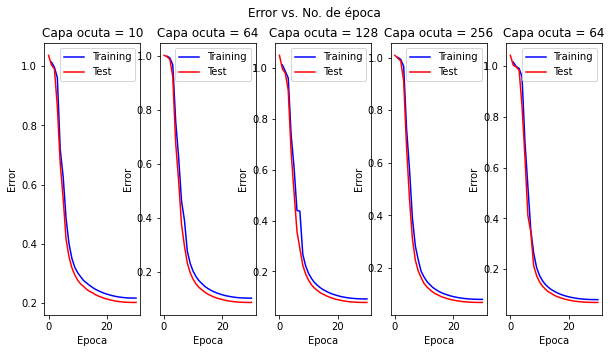

In [38]:
plt.figure(figsize=(10,5))
plt.suptitle('Error vs. No. de época')

plt.subplot(151)
plot_losses(history0)
plt.title('Capa ocuta = 10')

plt.subplot(152)
plot_losses(history1)
plt.title('Capa ocuta = 64')

plt.subplot(153)
plot_losses(history2)
plt.title('Capa ocuta = 128')

plt.subplot(154)
plot_losses(history3)
plt.title('Capa ocuta = 256')

plt.subplot(155)
plot_losses(history4)
plt.title('Capa ocuta = 64')

### Learning rate vs batch

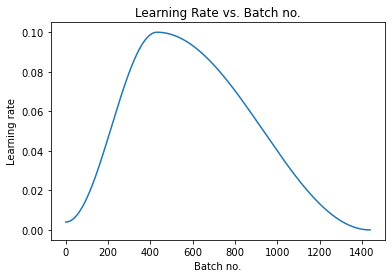

In [39]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
    
plot_lrs(history4)

## Testeo
Con las siguientes funciones podremos graficar un autput del modelo junto con la imagen original, de forma que podamos comparar.

In [40]:
#Test
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device) # Convert to a batch of 1
    yb = model(xb) # Get predictions from model
    return yb

Visualizamos una salida que elegimos al azar del conjunto de testeo, para cada capa oculta, co la imagen original correspondiente.

In [41]:
x_test, label = test_ds[9235] #le pasamos el numero de imagen del set de validación

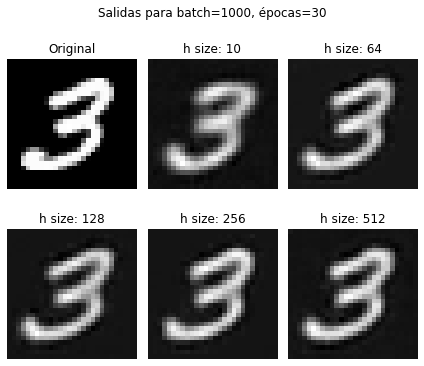

In [42]:
dims=(28,28)

plt.figure(figsize=(6,5.5))
plt.suptitle('Salidas para batch={}, épocas={}'.format(batch_size, epochs))

plt.subplot(231)
plt.imshow(x_test.reshape((28,28)))
plt.gray()
plt.title('Original')
plt.axis('off')

plt.subplot(232)
decoded_img0 = predict_image(x_test,model0).cpu().detach().numpy()
plt.imshow(decoded_img0.reshape(dims))
plt.title('h size: {}'.format(hidden_size0))
plt.axis('off')

plt.subplot(233)
decoded_img1 = predict_image(x_test,model1).cpu().detach().numpy()
plt.imshow(decoded_img1.reshape(dims))
plt.title('h size: {}'.format(hidden_size1))
plt.axis('off')

plt.subplot(234)
decoded_img2 = predict_image(x_test,model2).cpu().detach().numpy()
plt.imshow(decoded_img2.reshape(dims))
plt.title('h size: {}'.format(hidden_size2))
plt.axis('off')

plt.subplot(235)
decoded_img3 = predict_image(x_test,model3).cpu().detach().numpy()
plt.imshow(decoded_img3.reshape(dims))
plt.title('h size: {}'.format(hidden_size3))
plt.axis('off')

plt.subplot(236)
decoded_img4 = predict_image(x_test,model4).cpu().detach().numpy()
plt.imshow(decoded_img4.reshape(dims))
plt.title('h size: {}'.format(hidden_size4))
plt.axis('off')

plt.tight_layout()
plt.show()
#plot_autoencoder_outputs(img_orig,model1)
#plot_autoencoder_outputs(img_orig,model2)
#plot_autoencoder_outputs(img_orig,model3)
#plot_autoencoder_outputs(img_orig,model4)

## Testeo

Finalmente, vamos a calcular el error sobre el dataset de testeo o evaluación. En general, se espera que sea similar al obtenido para el dataset de validación. Con esto obenemos una nueva métrica para evaluar los resultados.

In [43]:
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size*2), device)

test_result=[]
test_result.append(evaluate(model0, test_loader).get('val_loss'))
test_result.append(evaluate(model1, test_loader).get('val_loss'))
test_result.append(evaluate(model2, test_loader).get('val_loss'))
test_result.append(evaluate(model3, test_loader).get('val_loss'))
test_result.append(evaluate(model4, test_loader).get('val_loss'))

test_result

[0.19979043304920197,
 0.08431626111268997,
 0.0762845054268837,
 0.06696203351020813,
 0.06702926754951477]

## Tabla comparativa

In [44]:
col = ['Capa oculta', 'Minimo error train', 'Minimo error val', 'Error conjunto test', 'Tiempo (min)']
rows = ['%d' % x for x in (10, 64, 128, 256, 512)]
data = [
       [hidden_size0, history0[-1].get('train_loss'), history0[-1].get('val_loss'), test_result[0], time0],
       [hidden_size1, history1[-1].get('train_loss'), history1[-1].get('val_loss'), test_result[1], time1],
       [hidden_size2, history2[-1].get('train_loss'), history2[-1].get('val_loss'), test_result[2], time2],
       [hidden_size3, history3[-1].get('train_loss'), history0[-1].get('val_loss'), test_result[3] ,time3],
       [hidden_size4, history4[-1].get('train_loss'), history0[-1].get('val_loss'), test_result[4] ,time4]
       ]

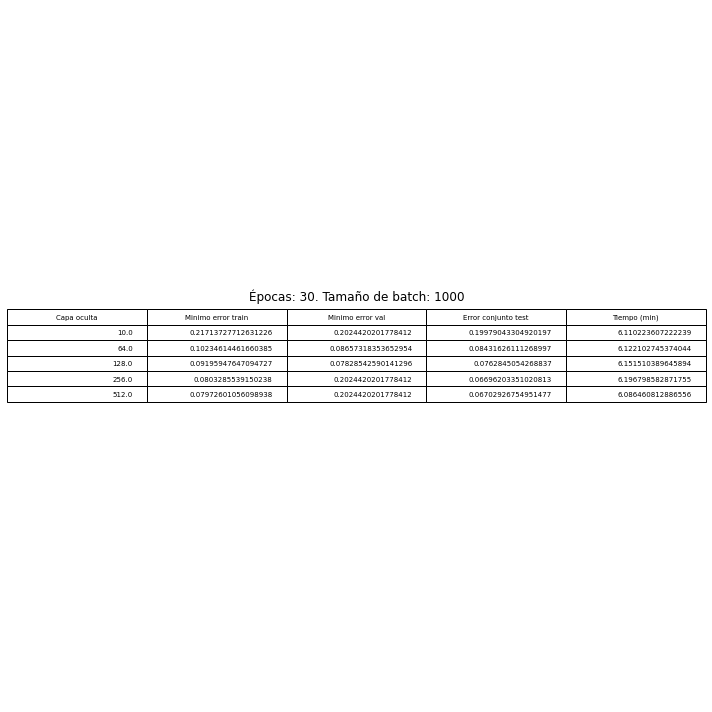

In [45]:
import numpy as np
import pandas as pd

fig, ax = plt.subplots(figsize=(10,10))

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

df = pd.DataFrame(data, columns=col)

ax.table(cellText=df.values, colLabels=df.columns, loc='center')

fig.tight_layout()
plt.title('Épocas: {}. Tamaño de batch: {}'.format(epochs, batch_size), y=0.6, pad=-14)
plt.show()

## Commit and upload the notebook

Finalemente, guardamos el trabajo en Jovian. Esto es muy util si queremos, además de conservar versiones, guardar las métricas de forma simple.

In [46]:
!pip install jovian --upgrade -q

import jovian

<IPython.core.display.Javascript object>

In [47]:
jovian.reset()

jovian.log_hyperparams(cant_epocas = epochs,
                       lr = max_lr,
                       batch=batch_size,
                       optimizador = 'SGD')

jovian.commit(project='Autoencoder Convolucional', outputs=['Autoencoder Convoluciona.pth'], environment=None)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ········
[jovian] Hyperparams logged.


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ai/paula-rj/Autoencoder Convolucional


<IPython.core.display.Javascript object>

Fuentes:

[Pytorch: from zero to GANs](http://jovian.ai)

https://nextjournal.com/gkoehler/pytorch-mnist

https://github.com/ardendertat/Applied-Deep-Learning-with-Keras/blob/master/notebooks/Part%203%20-%20Autoencoders.ipynb

[Guo, Xifeng & Liu, Xinwang & Zhu, En & Yin, Jianping. (2017). Deep Clustering with Convolutional Autoencoders. 373-382. 10.1007/978-3-319-70096-0_39. ](http://https://www.researchgate.net/figure/The-structure-of-proposed-Convolutional-AutoEncoders-CAE-for-MNIST-In-the-middle-there_fig1_320658590); codigo en [github](https://github.com/XifengGuo/DCEC/blob/master/metrics.py) (en keras).

https://debuggercafe.com/convolutional-variational-autoencoder-in-pytorch-on-mnist-dataset/